In [15]:
def data_preprocessing(file_path):
    with open(file_path,'r') as file:
        data=file.read()
        print("read data")
    return data

file_path = "C:/users/pantm/Downloads/text8/text8.txt"
data = data_preprocessing(file_path)

read data


In [18]:
len(data[:1000])

1000

In [ ]:
import numpy as np
from collections import Counter

# Data
#data = "hellow wrold ahowa reah and what is happenign and what you are trying to do m implementing skip gram is pain in the ass."

# Preprocessing function
def preprocess_text(corpus, min_count=1):
    words = corpus.lower().split()
    word_counts = Counter(words)
    vocab = {word: i for i, (word, count) in enumerate(word_counts.items()) if count >= min_count}
    vocab['UNK'] = len(vocab)
    idx_to_word = {i: word for word, i in vocab.items()}
    word_indices = [vocab.get(word, vocab['UNK']) for word in words]
    return vocab, idx_to_word, word_indices

# Generate skip-gram pairs
def generate_skip_grams(word_indices, window_size=2):
    skip_grams = []
    for i in range(len(word_indices)):
        target_word = word_indices[i]
        context_range = range(max(0, i - window_size), min(len(word_indices), i + window_size + 1))
        for j in context_range:
            if i != j:
                skip_grams.append((target_word, word_indices[j]))
    return skip_grams

# Process the data
vocab, idx_to_word, word_indices = preprocess_text(data[:100000])
skip_grams = generate_skip_grams(word_indices)

# Convert to numpy arrays for training
input_tensor = np.array([pair[0] for pair in skip_grams])
target_tensor = np.array([pair[1] for pair in skip_grams])

# Print some information for debugging
print(f"Vocabulary size: {len(vocab)}")
print(f"Number of skip-gram pairs: {len(skip_grams)}")
print(f"Max index in input tensor: {input_tensor.max()}")
print(f"Max index in target tensor: {target_tensor.max()}")

class SkipGramNumpy:
    def __init__(self, vocab_size, hidden_dim, neg_sample_size=5, lr=0.01):
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.neg_sample_size = neg_sample_size
        self.lr = lr
        
        # Initialize weights
        self.W1 = self.xavier_initialization(vocab_size,hidden_dim) * 0.01  # Input to hidden
        self.W2 = self.xavier_initialization(hidden_dim, vocab_size) * 0.01  # Hidden to output
        self.b1 = np.zeros(hidden_dim)
        self.b2 = np.zeros(vocab_size)
        
        # Adam optimization variables
        self.m_W1, self.v_W1 = np.zeros_like(self.W1), np.zeros_like(self.W1)
        self.m_W2, self.v_W2 = np.zeros_like(self.W2), np.zeros_like(self.W2)
        self.m_b1, self.v_b1 = np.zeros_like(self.b1), np.zeros_like(self.b1)
        self.m_b2, self.v_b2 = np.zeros_like(self.b2), np.zeros_like(self.b2)
        self.beta1, self.beta2, self.epsilon = 0.9, 0.999, 1e-8
        self.t = 0  # Time step for Adam
        

    def xavier_initialization(self,input_dim, output_dim):
        # Calculate the range for weights based on input and output dimensions
        limit = np.sqrt(6 / (input_dim + output_dim))
        
        # Generate weights using uniform distribution within the calculated range
        weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        return weights


        
    def batch_norm(self, h):
        """Batch normalization of the hidden layer."""
        mean = np.mean(h)
        std = np.std(h) + 1e-8  # Avoid division by zero
        return (h - mean) / std
    
    def forward(self, input_idx):
        # Hidden layer activation
        h = self.W1[input_idx].copy() + self.b1  # Shape: (hidden_dim,)
        h = self.batch_norm(h)
        h = np.tanh(h)
        
        # Output layer (no activation in forward pass)
        output = np.dot(h, self.W2) + self.b2  # Shape: (vocab_size,)
        return h, output
    
    
    def negative_sampling(self, target_idx):
        # Compute unigram distribution raised to 3/4 power
        word_freqs = np.array([self.word_counts[i] for i in range(self.vocab_size)], dtype=np.float32)
        probs = word_freqs ** 0.75
        probs[target_idx] = 0  # Exclude target word
        probs /= np.linalg.norm(probs, 1)  # Normalize using L1 norm

        # Efficient sampling with multinomial distribution
        neg_samples = np.random.multinomial(self.neg_sample_size, probs)
        neg_samples = np.where(neg_samples > 0)[0]  # Extract sampled indices

        return neg_samples

    
    def sigmoid(self, x):
        """Numerically stable sigmoid function"""
        return np.where(x >= 0, 
                       1 / (1 + np.exp(-x)),
                       np.exp(x) / (1 + np.exp(x)))
    
    def compute_gradients(self, input_idx, target_idx):
        # Forward pass
        h, output = self.forward(input_idx)
        
        # Get negative samples
        neg_indices = self.negative_sampling(target_idx)
        
        # Calculate sigmoid outputs for positive and negative samples
        pos_score = self.sigmoid(output[target_idx])
        neg_scores = self.sigmoid(output[neg_indices])
        
        # Initialize gradients
        grad_out = np.zeros(self.vocab_size)
        
        # Compute loss gradients
        # For positive sample: sigmoid(output) - 1
        grad_out[target_idx] = pos_score - 1.0
        
        # For negative samples: sigmoid(output)
        for neg_idx, neg_score in zip(neg_indices, neg_scores):
            grad_out[neg_idx] = neg_score
        
        # Backpropagation to hidden layer
        grad_h = np.dot(grad_out, self.W2.T)  # Shape: (hidden_dim,)
        
        # Backpropagation through tanh
        grad_tanh = (1 - h**2) * grad_h  # Shape: (hidden_dim,)
        
        # Calculate gradients for W1, W2, b1, b2
        grad_W1 = np.zeros_like(self.W1)
        grad_W1[input_idx] = grad_tanh  # Update only for the input word
        
        grad_W2 = np.outer(h, grad_out)  # Shape: (hidden_dim, vocab_size)
        
        grad_b1 = grad_tanh
        grad_b2 = grad_out
        
        return grad_W1, grad_W2, grad_b1, grad_b2
    
    def update_weights_adam(self, grad_W1, grad_W2, grad_b1, grad_b2):
        self.t += 1
        
        # Adam updates for W1
        self.m_W1 = self.beta1 * self.m_W1 + (1 - self.beta1) * grad_W1
        self.v_W1 = self.beta2 * self.v_W1 + (1 - self.beta2) * (grad_W1 ** 2)
        m_hat_W1 = self.m_W1 / (1 - self.beta1 ** self.t)
        v_hat_W1 = self.v_W1 / (1 - self.beta2 ** self.t)
        self.W1 -= self.lr * m_hat_W1 / (np.sqrt(v_hat_W1) + self.epsilon)
        
        # Adam updates for W2
        self.m_W2 = self.beta1 * self.m_W2 + (1 - self.beta1) * grad_W2
        self.v_W2 = self.beta2 * self.v_W2 + (1 - self.beta2) * (grad_W2 ** 2)
        m_hat_W2 = self.m_W2 / (1 - self.beta1 ** self.t)
        v_hat_W2 = self.v_W2 / (1 - self.beta2 ** self.t)
        self.W2 -= self.lr * m_hat_W2 / (np.sqrt(v_hat_W2) + self.epsilon)
        
        # Adam updates for b1
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * grad_b1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (grad_b1 ** 2)
        m_hat_b1 = self.m_b1 / (1 - self.beta1 ** self.t)
        v_hat_b1 = self.v_b1 / (1 - self.beta2 ** self.t)
        self.b1 -= self.lr * m_hat_b1 / (np.sqrt(v_hat_b1) + self.epsilon)
        
        # Adam updates for b2
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * grad_b2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (grad_b2 ** 2)
        m_hat_b2 = self.m_b2 / (1 - self.beta1 ** self.t)
        v_hat_b2 = self.v_b2 / (1 - self.beta2 ** self.t)
        self.b2 -= self.lr * m_hat_b2 / (np.sqrt(v_hat_b2) + self.epsilon)
    
    def calculate_loss(self, input_idx, target_idx):
        # Forward pass
        _, output = self.forward(input_idx)
        
        # Get negative samples
        neg_indices = self.negative_sampling(target_idx)
        
        # Calculate loss for positive sample
        pos_loss = -np.log(self.sigmoid(output[target_idx]) + 1e-9)
        
        # Calculate loss for negative samples
        neg_loss = -np.sum(np.log(1 - self.sigmoid(output[neg_indices]) + 1e-9))
        
        # Total loss
        total_loss = pos_loss + neg_loss
        
        return total_loss
    


    
    def train(self, input_tensor, target_tensor, epochs=10, batch_size=32):
        num_samples = len(input_tensor)
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            shuffled_inputs = input_tensor[indices]
            shuffled_targets = target_tensor[indices]
            
            total_loss = 0.0
            
            # Process in batches
            for i in range(0, num_samples, batch_size):
                batch_inputs = shuffled_inputs[i:min(i+batch_size, num_samples)]
                batch_targets = shuffled_targets[i:min(i+batch_size, num_samples)]
                
                batch_loss = 0.0
                for input_idx, target_idx in zip(batch_inputs, batch_targets):
                    # Compute gradients and update weights
                    grad_W1, grad_W2, grad_b1, grad_b2 = self.compute_gradients(input_idx, target_idx)
                    self.update_weights_adam(grad_W1, grad_W2, grad_b1, grad_b2)
                    
                    # Calculate loss
                    loss = self.calculate_loss(input_idx, target_idx)
                    batch_loss += loss
                
                total_loss += batch_loss
            
            print(f"Epoch {epoch+1}, Loss: {total_loss/num_samples:.4f}")
    
    def get_word_vector(self, word_idx):
        return self.W1[word_idx]
    
    def find_similar_words(self, word, vocab, idx_to_word, top_k=5):
        if word not in vocab:
            print(f"Word '{word}' not in vocabulary")
            return []
        
        word_idx = vocab[word]
        word_vec = self.get_word_vector(word_idx)
        
        similarities = []
        for idx, other_word in idx_to_word.items():
            if idx != word_idx:  # Skip the input word
                other_vec = self.get_word_vector(idx)
                # Cosine similarity
                similarity = np.dot(word_vec, other_vec) / (np.linalg.norm(word_vec) * np.linalg.norm(other_vec))
                similarities.append((other_word, similarity))
        
        # Sort by similarity (descending)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_k]

# Initialize and train the model
hidden_dim = 50
model = SkipGramNumpy(vocab_size=len(vocab), hidden_dim=hidden_dim, neg_sample_size=5, lr=0.01)
model.train(input_tensor, target_tensor, epochs=10, batch_size=32)

# Test the model - find similar words
test_words = ['and', 'what', 'is', 'to']
for word in test_words:
    if word in vocab:
        similar_words = model.find_similar_words(word, vocab, idx_to_word, top_k=3)
        print(f"Words similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")

Vocabulary size: 3510
Number of skip-gram pairs: 64614
Max index in input tensor: 3508
Max index in target tensor: 3508
Epoch 1, Loss: 2.7192
Epoch 2, Loss: 2.8549
Epoch 3, Loss: 2.7759
Epoch 4, Loss: 2.7967
Epoch 5, Loss: 2.7955
Epoch 6, Loss: 2.7057
Epoch 7, Loss: 2.6771
Epoch 8, Loss: 2.6672
Epoch 9, Loss: 2.6472
Epoch 10, Loss: 2.5830
Words similar to 'and':
  for: 0.6133
  the: 0.6114
  to: 0.5962
Words similar to 'what':
  misinterpret: 0.4352
  cercle: 0.4237
  embodying: 0.4196
Words similar to 'is':
  a: 0.7825
  the: 0.7720
  to: 0.7635
Words similar to 'to':
  a: 0.8271
  in: 0.8221
  the: 0.8100


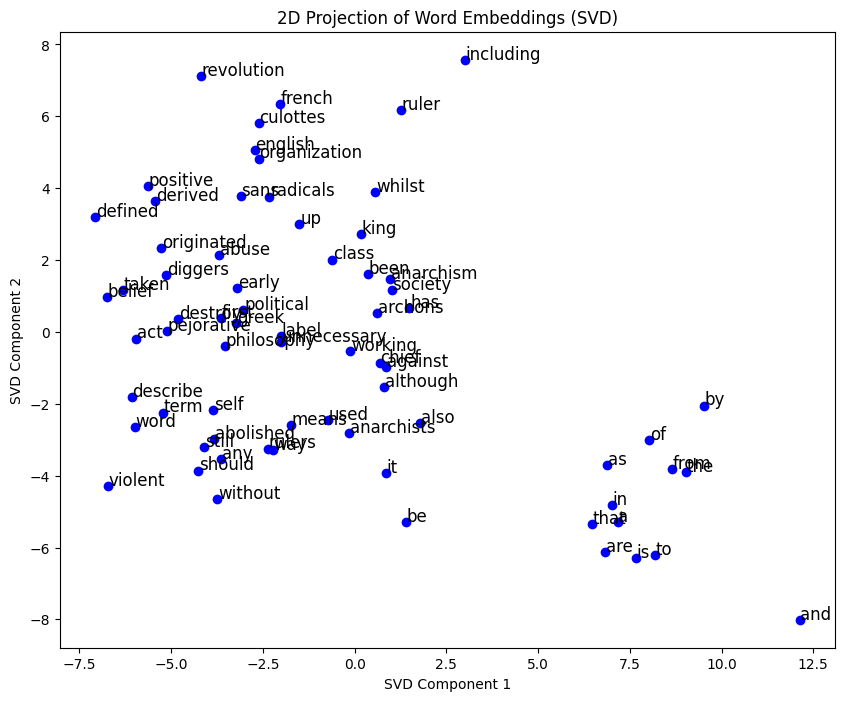

Words similar to 'violent':
  interactions: 0.4873
  gaze: 0.4841
  alternate: 0.4710
Words similar to 'word':
  nations: 0.5094
  study: 0.4831
  construction: 0.4548
Words similar to 'term':
  confused: 0.4931
  services: 0.4875
  warms: 0.4549
Words similar to 'describe':
  stimulation: 0.4984
  implies: 0.4625
  interest: 0.4523
Words similar to 'philosophy':
  models: 0.5325
  intervene: 0.5117
  structures: 0.4741
Words similar to 'chief':
  killing: 0.7460
  abacus: 0.5538
  king: 0.5424
Words similar to 'anarchists':
  war: 0.5077
  not: 0.5026
  some: 0.4598


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Extract learned word embeddings from the trained SkipGram model
word_embeddings = model.W1  # Shape: (vocab_size, hidden_dim)

# Apply SVD to reduce to 2D
svd = TruncatedSVD(n_components=2)
reduced_embeddings = svd.fit_transform(word_embeddings)  # Shape: (vocab_size, 2)

# Plot word embeddings
plt.figure(figsize=(10, 8))
for i, word in enumerate(list(vocab.keys())[:70]):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D Projection of Word Embeddings (SVD)")
plt.show()


test_words = ['violent', 'word', 'term', 'describe','philosophy','chief','anarchists']
for word in test_words:
    if word in vocab:
        similar_words = model.find_similar_words(word, vocab, idx_to_word, top_k=3)
        print(f"Words similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")


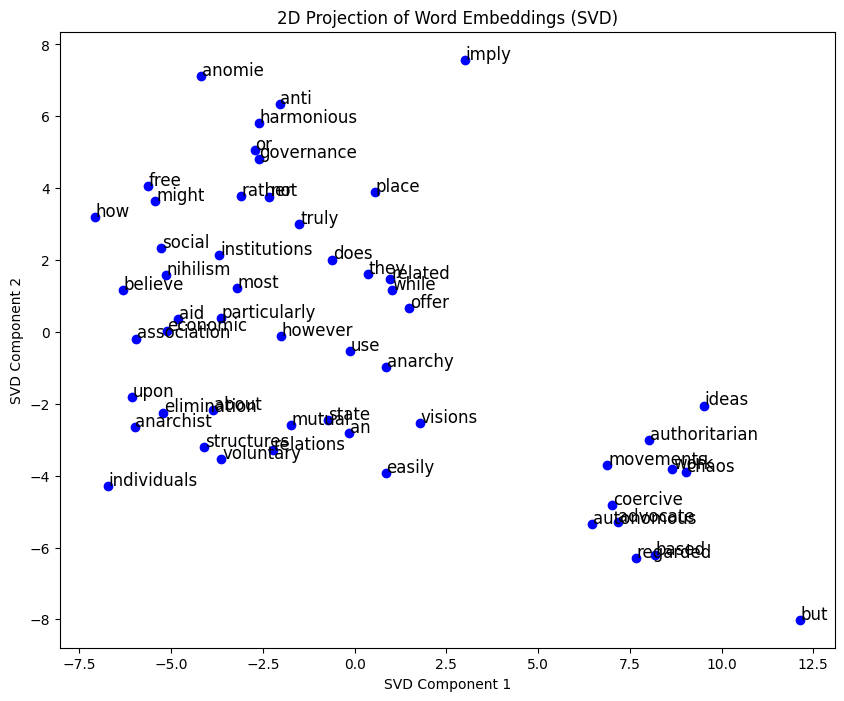

Words similar to 'king':
  archons: 0.5732
  chief: 0.5424
  abacus: 0.5213
Words similar to 'man':
  rain: 0.5316
  film: 0.4759
  resulted: 0.4660
Words similar to 'women':
  free: 0.5085
  defines: 0.4649
  feminist: 0.4424


In [30]:
plt.figure(figsize=(10, 8))
for i, word in enumerate(list(vocab.keys())[76:130]):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D Projection of Word Embeddings (SVD)")
plt.show()

test_words = ['king', 'man', 'women', 'queen']
for word in test_words:
    if word in vocab:
        similar_words = model.find_similar_words(word, vocab, idx_to_word, top_k=3)
        print(f"Words similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")

In [ ]:
# Process the data
vocab, idx_to_word, word_indices = preprocess_text(data[:200000])
skip_grams = generate_skip_grams(word_indices)

# Convert to numpy arrays for training
input_tensor = np.array([pair[0] for pair in skip_grams])
target_tensor = np.array([pair[1] for pair in skip_grams])

# Print some information for debugging
print(f"Vocabulary size: {len(vocab)}")
print(f"Number of skip-gram pairs: {len(skip_grams)}")
print(f"Max index in input tensor: {input_tensor.max()}")
print(f"Max index in target tensor: {target_tensor.max()}")



hidden_dim = 50
model = SkipGramNumpy(vocab_size=len(vocab), hidden_dim=hidden_dim, neg_sample_size=10, lr=0.01)
model.train(input_tensor, target_tensor, epochs=10, batch_size=32)


Vocabulary size: 6064
Number of skip-gram pairs: 133654
Max index in input tensor: 6062
Max index in target tensor: 6062
Epoch 1, Loss: 3.4086


## Hyperpaprameter tuning 
- running a similar instance on a different machine where 


🔹 Embedding Dim = 50 ✅ (Try 100 for richer semantic meanings)
🔹 Negative Sampling Window = 10 ✅ (Try 15 if needed for better rare word discrimination)
🔹 Other tuning considerations: Learning rate scheduling, batch size tweaks, regularization.
🔹 Embedding Dim = 50 ✅ (Try 100 for richer semantic meanings)
🔹 Negative Sampling Window = 10 ✅ (Try 15 if needed for better rare word discrimination)
🔹 Other tuning considerations: Learning rate scheduling, batch size tweaks, regularization.

- what combinations of the above will help in increasing the performance
  - neg_sample_size
  - embedding_dim
  - context_window_size
  - w
- will changing the initialization strategy helps?
- training DLL lectures can help? 
  - when do we use the dropout?
  - 
- can i try clustering over here?
  -[ ] how can i provide the syntactic and semantic over here. Need to showcase




strategy:
- use the same prev code and try to understand how things are implemented over there
- strategy
  - change the hyperparameters for this. first evaluate the hyperparameters and make the list
    - prepare a list of the possible n

In [37]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import Counter

class SkipGram:
    def __init__(self, vocab_size, embedding_dim, num_negative_samples=5, momentum=0.9):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_negative_samples = num_negative_samples
        self.momentum = momentum
        
        # Initialize embeddings
        self.W1 = torch.randn(vocab_size, embedding_dim) * 0.1
        self.W2 = torch.randn(vocab_size, embedding_dim) * 0.1
        
        self.eta = 0.01
        
        # Initialize velocity terms for momentum
        self.v_W1 = torch.zeros_like(self.W1)
        self.v_W2 = torch.zeros_like(self.W2)
    
    def forward(self, target_word, context_word, negative_samples):
        target_emb = self.W1[target_word]
        context_emb = self.W2[context_word]
        neg_emb = self.W2[negative_samples]
        
        pos_score = torch.sum(target_emb * context_emb, dim=1)
        pos_loss = -F.logsigmoid(pos_score)
        
        neg_score = torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()
        neg_loss = -torch.sum(F.logsigmoid(-neg_score), dim=1)
        
        return pos_loss + neg_loss, target_emb, context_emb, neg_emb
    
    def gradient_descent(self, dataloader, n_epoch=10):
        for epoch in range(n_epoch):
            total_loss = 0
            for target_word, context_word, negative_samples in dataloader:
                loss, target_emb, context_emb, neg_emb = self.forward(target_word, context_word, negative_samples)
                total_loss += loss.mean().item()
                
                # Gradients for positive samples
                d_pos = -torch.sigmoid(-torch.sum(target_emb * context_emb, dim=1)).unsqueeze(1) * context_emb
                d_context = -torch.sigmoid(-torch.sum(target_emb * context_emb, dim=1)).unsqueeze(1) * target_emb
                
                # Gradients for negative samples
                d_neg = torch.sigmoid(torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()).unsqueeze(2) * neg_emb
                d_target_neg = torch.sum(torch.sigmoid(torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()).unsqueeze(2) * neg_emb, dim=1)
                
                # Compute momentum updates
                self.v_W1[target_word] = self.momentum * self.v_W1[target_word] - self.eta * (d_pos + d_target_neg)
                self.v_W2[context_word] = self.momentum * self.v_W2[context_word] - self.eta * d_context
                self.v_W2[negative_samples] = self.momentum * self.v_W2[negative_samples] - self.eta * d_neg
                
                # Apply updates
                self.W1[target_word] += self.v_W1[target_word]
                self.W2[context_word] += self.v_W2[context_word]
                self.W2[negative_samples] += self.v_W2[negative_samples]
            
            print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')
    
    def get_word_embedding(self, word_idx):
        return self.W1[word_idx].detach().numpy()

class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, text, window_size=2, num_negative_samples=5):
        words = text.lower().split()
        word_counts = Counter(words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.vocab_size = len(self.vocab)
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}
        
        word_indices = [self.vocab[word] for word in words if word in self.vocab]
        
        self.skip_grams = []
        for i in range(len(word_indices)):
            for j in range(max(0, i - window_size), min(len(word_indices), i + window_size + 1)):
                if i != j:
                    self.skip_grams.append((word_indices[i], word_indices[j]))
        
        self.num_negative_samples = num_negative_samples
        
        word_freqs = np.array([count for _, count in word_counts.most_common()])
        word_freqs = word_freqs ** 0.75
        self.sampling_weights = word_freqs / np.sum(word_freqs)
    
    def __len__(self):
        return len(self.skip_grams)
    
    def __getitem__(self, idx):
        target_word, context_word = self.skip_grams[idx]
        negative_samples = np.random.choice(
            self.vocab_size, 
            size=self.num_negative_samples, 
            p=self.sampling_weights, 
            replace=False
        )
        return torch.tensor(target_word), torch.tensor(context_word), torch.tensor(negative_samples)

def train_skip_gram_with_negative_sampling(text, embedding_dim=100, window_size=2, 
                                          num_negative_samples=5, batch_size=32, epochs=5):
    dataset = SkipGramDataset(text, window_size, num_negative_samples)
    print("Vocab size is:", dataset.vocab_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = SkipGram(dataset.vocab_size, embedding_dim, num_negative_samples)
    model.gradient_descent(dataloader, n_epoch=epochs)
    
    return model, dataset.vocab, dataset.idx_to_word

def find_similar_words(word, model, vocab, idx_to_word, top_k=5):
    if word not in vocab:
        return []
    
    word_idx = vocab[word]
    word_vector = model.get_word_embedding(word_idx)
    
    similarities = []
    for idx in range(len(vocab)):
        if idx != word_idx:
            vector = model.get_word_embedding(idx)
            similarity = np.dot(word_vector, vector) / (np.linalg.norm(word_vector) * np.linalg.norm(vector))
            similarities.append((idx_to_word[idx], similarity))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

if __name__ == "__main__":
    text = data[:10000]
    model, vocab, idx_to_word = train_skip_gram_with_negative_sampling(
        text, embedding_dim=300, epochs=100, batch_size=128
    )
    
    test_words = ['king', 'queen', 'man', 'woman', 'violent', 'word', 'term', 'describe', 'philosophy', 'chief', 'anarchists']
    for each_word in test_words:
        similar_words = find_similar_words(each_word, model, vocab, idx_to_word)
        print(f"Words similar to '{each_word}': {similar_words}")


Vocab size is: 628
Epoch 1, Loss: 4.1669
Epoch 2, Loss: 4.1462
Epoch 3, Loss: 4.1326
Epoch 4, Loss: 4.1299
Epoch 5, Loss: 4.1239
Epoch 6, Loss: 4.1231
Epoch 7, Loss: 4.1206
Epoch 8, Loss: 4.1175
Epoch 9, Loss: 4.1142
Epoch 10, Loss: 4.1122
Epoch 11, Loss: 4.1083
Epoch 12, Loss: 4.1050
Epoch 13, Loss: 4.1019
Epoch 14, Loss: 4.1004
Epoch 15, Loss: 4.0985
Epoch 16, Loss: 4.0967
Epoch 17, Loss: 4.0873
Epoch 18, Loss: 4.0947
Epoch 19, Loss: 4.0851
Epoch 20, Loss: 4.0822
Epoch 21, Loss: 4.0812
Epoch 22, Loss: 4.0750
Epoch 23, Loss: 4.0715
Epoch 24, Loss: 4.0721
Epoch 25, Loss: 4.0682
Epoch 26, Loss: 4.0673
Epoch 27, Loss: 4.0593
Epoch 28, Loss: 4.0555
Epoch 29, Loss: 4.0594
Epoch 30, Loss: 4.0569
Epoch 31, Loss: 4.0505
Epoch 32, Loss: 4.0470
Epoch 33, Loss: 4.0525
Epoch 34, Loss: 4.0428
Epoch 35, Loss: 4.0446
Epoch 36, Loss: 4.0489
Epoch 37, Loss: 4.0379
Epoch 38, Loss: 4.0346
Epoch 39, Loss: 4.0244
Epoch 40, Loss: 4.0308
Epoch 41, Loss: 4.0280
Epoch 42, Loss: 4.0231
Epoch 43, Loss: 4.0215
E

In [38]:
text = data[:10000]
model, vocab, idx_to_word = train_skip_gram_with_negative_sampling(
    text, embedding_dim=300, epochs=100, batch_size=256
)

test_words = ['king', 'queen', 'man', 'woman', 'violent', 'word', 'term', 'describe', 'philosophy', 'chief', 'anarchists']
for each_word in test_words:
    similar_words = find_similar_words(each_word, model, vocab, idx_to_word)
    print(f"Words similar to '{each_word}': {similar_words}")


Vocab size is: 628
Epoch 1, Loss: 4.1729
Epoch 2, Loss: 4.1456
Epoch 3, Loss: 4.1302
Epoch 4, Loss: 4.1229
Epoch 5, Loss: 4.1173
Epoch 6, Loss: 4.1177
Epoch 7, Loss: 4.1106
Epoch 8, Loss: 4.1052
Epoch 9, Loss: 4.1033
Epoch 10, Loss: 4.0998
Epoch 11, Loss: 4.0959
Epoch 12, Loss: 4.0934
Epoch 13, Loss: 4.0863
Epoch 14, Loss: 4.0899
Epoch 15, Loss: 4.0882
Epoch 16, Loss: 4.0728
Epoch 17, Loss: 4.0737
Epoch 18, Loss: 4.0708
Epoch 19, Loss: 4.0670
Epoch 20, Loss: 4.0628
Epoch 21, Loss: 4.0545
Epoch 22, Loss: 4.0626
Epoch 23, Loss: 4.0486
Epoch 24, Loss: 4.0401
Epoch 25, Loss: 4.0452
Epoch 26, Loss: 4.0462
Epoch 27, Loss: 4.0421
Epoch 28, Loss: 4.0369
Epoch 29, Loss: 4.0350
Epoch 30, Loss: 4.0291
Epoch 31, Loss: 4.0202
Epoch 32, Loss: 4.0219
Epoch 33, Loss: 4.0233
Epoch 34, Loss: 4.0237
Epoch 35, Loss: 4.0089
Epoch 36, Loss: 4.0082
Epoch 37, Loss: 4.0048
Epoch 38, Loss: 4.0043
Epoch 39, Loss: 4.0058
Epoch 40, Loss: 3.9933
Epoch 41, Loss: 3.9948
Epoch 42, Loss: 3.9912
Epoch 43, Loss: 3.9837
E

In [39]:
text = data[:500000]
model, vocab, idx_to_word = train_skip_gram_with_negative_sampling(
    text, embedding_dim=300, epochs=10, batch_size=256
)

test_words = ['king', 'queen', 'man', 'woman', 'violent', 'word', 'term', 'describe', 'philosophy', 'chief', 'anarchists']
for each_word in test_words:
    similar_words = find_similar_words(each_word, model, vocab, idx_to_word)
    print(f"Words similar to '{each_word}': {similar_words}")

Vocab size is: 10638
Epoch 1, Loss: 4.1429
Epoch 2, Loss: 4.1321
Epoch 3, Loss: 4.1304
Epoch 4, Loss: 4.1276
Epoch 5, Loss: 4.1263
Epoch 6, Loss: 4.1245
Epoch 7, Loss: 4.1223
Epoch 8, Loss: 4.1218
Epoch 9, Loss: 4.1204
Epoch 10, Loss: 4.1188
Words similar to 'king': [('age', 0.29974574), ('spanish', 0.25356054), ('number', 0.24533378), ('modern', 0.24490434), ('roles', 0.23910224)]
Words similar to 'queen': [('presidential', 0.21413381), ('dag', 0.19629097), ('alone', 0.19198781), ('expenses', 0.18896568), ('elections', 0.18606949)]
Words similar to 'man': [('woman', 0.29722556), ('wrong', 0.2953903), ('clear', 0.28362504), ('he', 0.26281467), ('possible', 0.25979638)]
Words similar to 'woman': [('man', 0.29722556), ('require', 0.21575911), ('answer', 0.2094713), ('metal', 0.20921253), ('timescale', 0.20286565)]
Words similar to 'violent': [('tending', 0.20008464), ('achieved', 0.19444527), ('order', 0.19372465), ('derivation', 0.19258033), ('hillsdale', 0.1891394)]
Words similar to 'w

## implement adagrad 

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import Counter

class SkipGram:
    def __init__(self, vocab_size, embedding_dim, num_negative_samples=5, epsilon=1e-8,eta=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_negative_samples = num_negative_samples
        
        # Initialize embeddings
        self.W1 = torch.empty(vocab_size, embedding_dim).uniform_(-1, 1)
        self.W2 = torch.empty(vocab_size, embedding_dim).uniform_(-1, 1)
        
        self.eta = eta
        
        # Initialize squared gradient accumulators for AdaGrad
        self.G_W1 = torch.zeros_like(self.W1)
        self.G_W2 = torch.zeros_like(self.W2)
        self.epsilon = epsilon
    
    def forward(self, target_word, context_word, negative_samples):
        target_emb = self.W1[target_word]
        context_emb = self.W2[context_word]
        neg_emb = self.W2[negative_samples]
        
        pos_score = torch.sum(target_emb * context_emb, dim=1)
        pos_loss = -F.logsigmoid(pos_score)
        
        neg_score = torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()
        neg_loss = -torch.sum(F.logsigmoid(-neg_score), dim=1)
        
        return pos_loss + neg_loss, target_emb, context_emb, neg_emb
    
    def gradient_descent(self, dataloader, n_epoch=10):
        for epoch in range(n_epoch):
            total_loss = 0
            for target_word, context_word, negative_samples in dataloader:
                loss, target_emb, context_emb, neg_emb = self.forward(target_word, context_word, negative_samples)
                total_loss += loss.mean().item()
                
                # Gradients for positive samples
                d_pos = -torch.sigmoid(-torch.sum(target_emb * context_emb, dim=1)).unsqueeze(1) * context_emb
                d_context = -torch.sigmoid(-torch.sum(target_emb * context_emb, dim=1)).unsqueeze(1) * target_emb
                
                # Gradients for negative samples
                d_neg = torch.sigmoid(torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()).unsqueeze(2) * neg_emb
                d_target_neg = torch.sum(torch.sigmoid(torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze()).unsqueeze(2) * neg_emb, dim=1)
                
                # Update squared gradients
                self.G_W1[target_word] += (d_pos + d_target_neg) ** 2
                self.G_W2[context_word] += d_context ** 2
                self.G_W2[negative_samples] += d_neg ** 2
                
                # Compute AdaGrad updates
                self.W1[target_word] -= self.eta * (d_pos + d_target_neg) / (torch.sqrt(self.G_W1[target_word]) + self.epsilon)
                self.W2[context_word] -= self.eta * d_context / (torch.sqrt(self.G_W2[context_word]) + self.epsilon)
                self.W2[negative_samples] -= self.eta * d_neg / (torch.sqrt(self.G_W2[negative_samples]) + self.epsilon)
            
            print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')
    
    def get_word_embedding(self, word_idx):
        return self.W1[word_idx].detach().numpy()

class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, text, window_size=2, num_negative_samples=5):
        words = text.lower().split()
        word_counts = Counter(words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.vocab = {k:v for k,v in self.vocab.items() if v> 3}
        self.vocab_size = len(self.vocab)
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}
        
        word_indices = [self.vocab[word] for word in words if word in self.vocab]
        
        self.skip_grams = []
        for i in range(len(word_indices)):
            for j in range(max(0, i - window_size), min(len(word_indices), i + window_size + 1)):
                if i != j:
                    self.skip_grams.append((word_indices[i], word_indices[j]))
        
        self.num_negative_samples = num_negative_samples
        
        word_freqs = np.array([count for _, count in word_counts.most_common()])
        word_freqs = word_freqs ** 0.75
        self.sampling_weights = word_freqs / np.sum(word_freqs)
    
    def __len__(self):
        return len(self.skip_grams)
    
    def __getitem__(self, idx):
        # change it to the #pytorch
        
        target_word, context_word = self.skip_grams[idx]
        negative_samples = np.random.choice(
            self.vocab_size, 
            size=self.num_negative_samples, 
            p=self.sampling_weights, 
            replace=False
        )
        return torch.tensor(target_word), torch.tensor(context_word), torch.tensor(negative_samples)

def train_skip_gram_with_negative_sampling(text, embedding_dim=100, window_size=2, 
                                          num_negative_samples=5, batch_size=32, epochs=5):
    dataset = SkipGramDataset(text, window_size, num_negative_samples)
    print("Vocab size is:", dataset.vocab_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = SkipGram(dataset.vocab_size, embedding_dim, num_negative_samples)
    model.gradient_descent(dataloader, n_epoch=epochs)
    
    return model, dataset.vocab, dataset.idx_to_word

def find_similar_words(word, model, vocab, idx_to_word, top_k=5):
    if word not in vocab:
        return []
    
    word_idx = vocab[word]
    word_vector = model.get_word_embedding(word_idx)
    
    similarities = []
    for idx in range(len(vocab)):
        if idx != word_idx:
            vector = model.get_word_embedding(idx)
            similarity = np.dot(word_vector, vector) / (np.linalg.norm(word_vector) * np.linalg.norm(vector))
            similarities.append((idx_to_word[idx], similarity))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

if __name__ == "__main__":
    text = data[:200000]
    model, vocab, idx_to_word = train_skip_gram_with_negative_sampling(
        text, embedding_dim=300, epochs=50, batch_size=256
    )
    
    test_words = ['king', 'queen', 'man', 'woman', 'violent', 'word', 'term', 'describe', 'philosophy', 'chief', 'anarchists']
    for each_word in test_words:
        similar_words = find_similar_words(each_word, model, vocab, idx_to_word)
        print(f"Words similar to '{each_word}': {similar_words}")


Vocab size is: 6063
Epoch 1, Loss: 4.1846
Epoch 2, Loss: 4.1524
Epoch 3, Loss: 4.1406
Epoch 4, Loss: 4.1345
Epoch 5, Loss: 4.1300
Epoch 6, Loss: 4.1275
Epoch 7, Loss: 4.1255
Epoch 8, Loss: 4.1241
Epoch 9, Loss: 4.1231
Epoch 10, Loss: 4.1218
Epoch 11, Loss: 4.1200
Epoch 12, Loss: 4.1191
Epoch 13, Loss: 4.1177
Epoch 14, Loss: 4.1171
Epoch 15, Loss: 4.1155
Epoch 16, Loss: 4.1146
Epoch 17, Loss: 4.1144
Epoch 18, Loss: 4.1137
Epoch 19, Loss: 4.1129
Epoch 20, Loss: 4.1111
Epoch 21, Loss: 4.1111
Epoch 22, Loss: 4.1111
Epoch 23, Loss: 4.1095
Epoch 24, Loss: 4.1088
Epoch 25, Loss: 4.1073
Epoch 26, Loss: 4.1070
Epoch 27, Loss: 4.1073
Epoch 28, Loss: 4.1060
Epoch 29, Loss: 4.1058
Epoch 30, Loss: 4.1066
Epoch 31, Loss: 4.1053
Epoch 32, Loss: 4.1034
Epoch 33, Loss: 4.1033
Epoch 34, Loss: 4.1032
Epoch 35, Loss: 4.1019
Epoch 36, Loss: 4.1015
Epoch 37, Loss: 4.1002
Epoch 38, Loss: 4.0995
Epoch 39, Loss: 4.0992
Epoch 40, Loss: 4.0985
Epoch 41, Loss: 4.0988
Epoch 42, Loss: 4.0978
Epoch 43, Loss: 4.0965


In [48]:
text = data[:5000000]
model, vocab, idx_to_word = train_skip_gram_with_negative_sampling(
    text, embedding_dim=300, epochs=5, batch_size=512
)

test_words = ['king', 'queen', 'man', 'woman', 'violent', 'word', 'term', 'describe', 'philosophy', 'chief', 'anarchists']
for each_word in test_words:
    similar_words = find_similar_words(each_word, model, vocab, idx_to_word)
    print(f"Words similar to '{each_word}': {similar_words}")

Vocab size is: 47046
Epoch 1, Loss: 4.1369
Epoch 2, Loss: 4.1213
Epoch 3, Loss: 4.1179
Epoch 4, Loss: 4.1154
Epoch 5, Loss: 4.1135
Words similar to 'king': [('apok', 0.2534913), ('ridge', 0.24328324), ('unconfessed', 0.2415705), ('infers', 0.23956077), ('dies', 0.22722411)]
Words similar to 'queen': [('investment', 0.25251126), ('fw', 0.23841542), ('neared', 0.22631387), ('glosses', 0.22419377), ('merit', 0.22104673)]
Words similar to 'man': [('shown', 0.3018155), ('true', 0.26967224), ('alien', 0.26404774), ('tone', 0.25889605), ('still', 0.25169602)]
Words similar to 'woman': [('nun', 0.24860886), ('refer', 0.23446141), ('cavefish', 0.23426518), ('aren', 0.23305304), ('append', 0.23281123)]
Words similar to 'violent': [('deemed', 0.2518672), ('forgot', 0.24570918), ('action', 0.24439137), ('considered', 0.2383007), ('tend', 0.2269726)]
Words similar to 'word': [('same', 0.32639375), ('conclusion', 0.32452488), ('has', 0.31120238), ('burying', 0.30222777), ('goal', 0.29084092)]
Words 

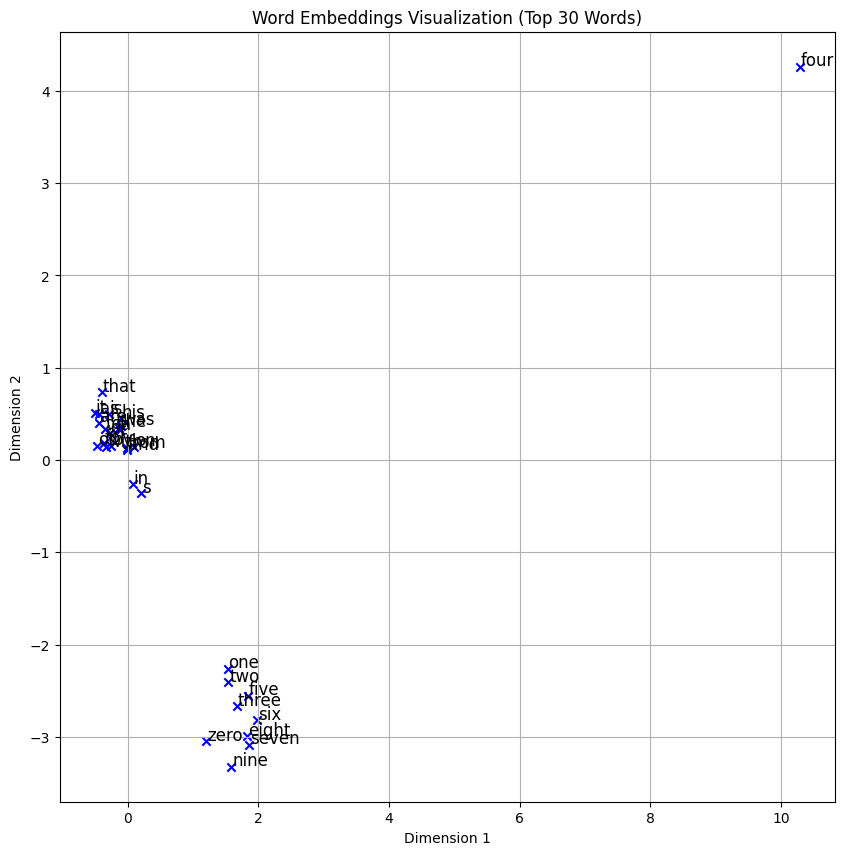

'king' - 'man' + 'woman' ≈ 'biologists'


In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Visualization using SVD
def visualize_embeddings(embeddings, word_to_idx, idx_to_word, top_n=10):
    # Select top N words for visualization
    selected_words = list(word_to_idx.keys())[:top_n]
    selected_indices = [word_to_idx[word] for word in selected_words]
    selected_embeddings = embeddings[selected_indices]

    # Reduce dimensions to 2D using SVD
    svd = TruncatedSVD(n_components=2)
    reduced_embeddings = svd.fit_transform(selected_embeddings)

    # Plot embeddings in 2D space
    plt.figure(figsize=(10, 10))
    for i, word in enumerate(selected_words):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, marker='x', color='blue')
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    plt.title("Word Embeddings Visualization (Top {} Words)".format(top_n))
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Word similarity analysis
def word_similarity_analysis(embeddings, word_to_idx):
    def find_closest_word(vector, embeddings, word_to_idx, idx_to_word):
        similarities = np.dot(embeddings, vector)  # Cosine similarity
        closest_idx = np.argmax(similarities)
        return idx_to_word[closest_idx]

    # Example semantic relationship
    king_vec = embeddings[word_to_idx['king']]
    man_vec = embeddings[word_to_idx['man']]
    woman_vec = embeddings[word_to_idx['woman']]
    expected_queen_vec = king_vec - man_vec + woman_vec

    # Find the closest word to the expected vector
    closest_word = find_closest_word(expected_queen_vec, embeddings, word_to_idx, idx_to_word)
    print(f"'king' - 'man' + 'woman' ≈ '{closest_word}'")

# Example usage
visualize_embeddings(model.W1, vocab, idx_to_word, top_n=30)
word_similarity_analysis(model.W1, vocab)